In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_path = '/kaggle/input/ecommerce-data/data.csv'
df = pd.read_csv(data_path, encoding='ISO-8859-1')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# Data Cleaning
df['Description'] = df['Description'].fillna('No Description')
df['CustomerID'] = df['CustomerID'].fillna(-1).astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  541909 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  int64         
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 33.1+ MB


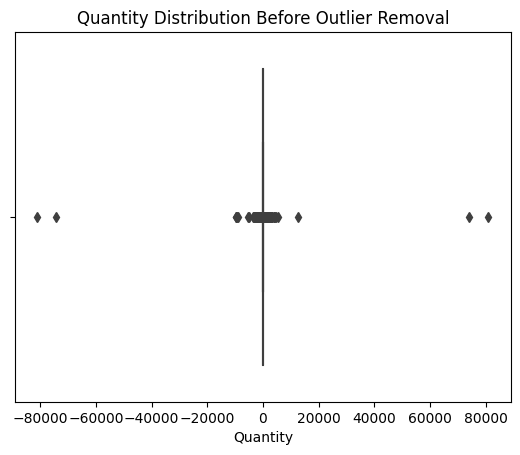

In [6]:
# EDA
sns.boxplot(data=df, x='Quantity')
plt.title('Quantity Distribution Before Outlier Removal')
plt.show()

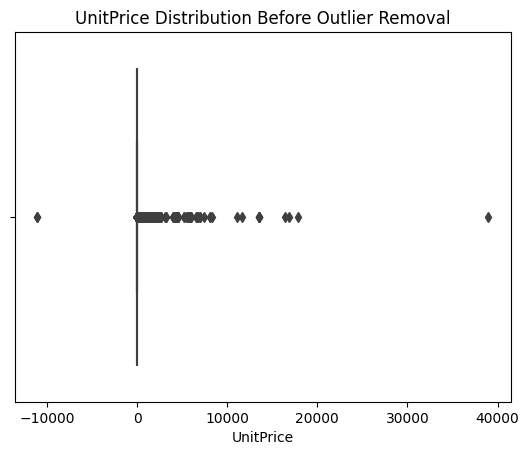

In [7]:
sns.boxplot(data=df, x='UnitPrice')
plt.title('UnitPrice Distribution Before Outlier Removal')
plt.show()

In [8]:
# Outlier Removal
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

data_no_outliers = remove_outliers(df, 'Quantity')
data_no_outliers = remove_outliers(data_no_outliers, 'UnitPrice')

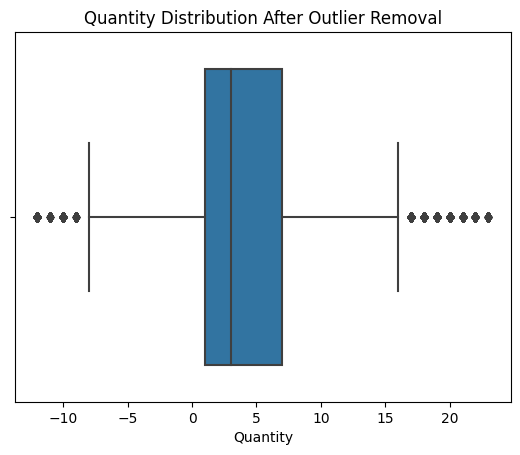

In [9]:
# EDA after outlier removal
sns.boxplot(data=data_no_outliers, x='Quantity')
plt.title('Quantity Distribution After Outlier Removal')
plt.show()

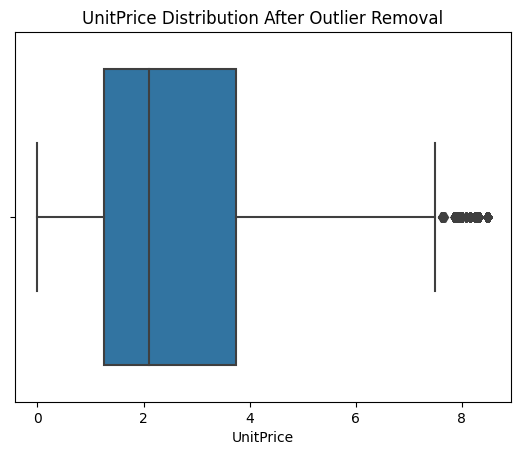

In [10]:
sns.boxplot(data=data_no_outliers, x='UnitPrice')
plt.title('UnitPrice Distribution After Outlier Removal')
plt.show()

In [11]:
# Analysis of the shape before and after
print("Shape before outlier removal:", df.shape)
print("Shape after outlier removal:", data_no_outliers.shape)

Shape before outlier removal: (541909, 8)
Shape after outlier removal: (450820, 8)


In [12]:
# Feature Engineering
invoice_date = data_no_outliers['InvoiceDate']
data_no_outliers['Year'] = invoice_date.dt.year
data_no_outliers['Month'] = invoice_date.dt.month
data_no_outliers['Day'] = invoice_date.dt.day
data_no_outliers['DayOfWeek'] = invoice_date.dt.dayofweek
data_no_outliers['Hour'] = invoice_date.dt.hour
data_no_outliers['TotalPrice'] = data_no_outliers['Quantity'] * data_no_outliers['UnitPrice']

# Display the new features
print(data_no_outliers[['InvoiceDate', 'Year', 'Month', 'Day', 'DayOfWeek', 'Hour', 'TotalPrice']].head())

          InvoiceDate  Year  Month  Day  DayOfWeek  Hour  TotalPrice
0 2010-12-01 08:26:00  2010     12    1          2     8       15.30
1 2010-12-01 08:26:00  2010     12    1          2     8       20.34
2 2010-12-01 08:26:00  2010     12    1          2     8       22.00
3 2010-12-01 08:26:00  2010     12    1          2     8       20.34
4 2010-12-01 08:26:00  2010     12    1          2     8       20.34


In [13]:
# RFM Analysis
current_date = invoice_date.max() + pd.Timedelta(days=1)
rfm = data_no_outliers.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)

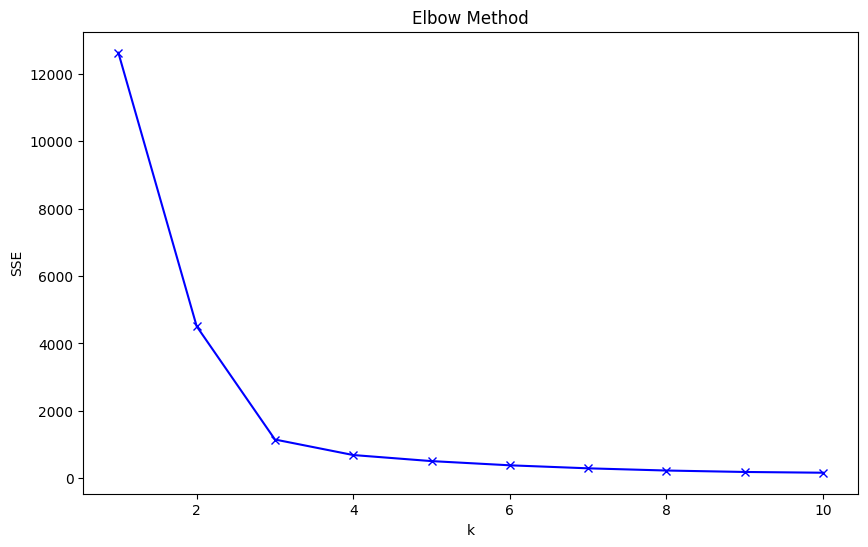

In [14]:
# Elbow Method for KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled_df)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [15]:
# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
print(cluster_summary)

        Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0          31.4       5.9    1227.8  2814
1         295.5       1.5     242.3   615
2           1.0    2344.0  857709.0     1
3         154.7       2.4     421.8   778


In [16]:
# Purchase Classification
bulk_threshold = 50
frequent_threshold = 12

data_no_outliers['PurchaseClass'] = 1

data_no_outliers.loc[data_no_outliers['Quantity'] > bulk_threshold, 'PurchaseClass'] = 2

purchase_freq = data_no_outliers.groupby('CustomerID')['InvoiceDate'].nunique()
data_no_outliers['CustomerFrequency'] = data_no_outliers['CustomerID'].map(purchase_freq)
data_no_outliers.loc[data_no_outliers['CustomerFrequency'] > frequent_threshold, 'PurchaseClass'] = 3

In [17]:
# Feature Creation
invoice_date = data_no_outliers['InvoiceDate']
data_no_outliers['Quarter'] = invoice_date.dt.to_period('Q').dt.start_time

data_no_outliers['CustomerAge'] = 30  # Placeholder
data_no_outliers['CustomerCountry'] = data_no_outliers['Country']

data_no_outliers['AvgPurchaseValue'] = data_no_outliers.groupby('CustomerID')['TotalPrice'].transform('mean')
data_no_outliers['DaysSinceLastPurchase'] = (current_date - data_no_outliers.groupby('CustomerID')['InvoiceDate'].transform('max')).dt.days


In [18]:
# One-Hot Encoding
data_encoded = pd.get_dummies(data_no_outliers, columns=['Month', 'Quarter', 'CustomerCountry'], drop_first=True)

In [19]:
# Model Prep
X = data_encoded.drop(['PurchaseClass', 'CustomerID', 'InvoiceNo', 'Description', 'StockCode', 'InvoiceDate', 'Country'], axis=1)
y = data_encoded['PurchaseClass']

X_selected = X[['TotalPrice', 'Quantity', 'AvgPurchaseValue', 'DaysSinceLastPurchase'] +
               [col for col in X.columns if col.startswith('Month_') or col.startswith('Quarter_')]]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8400359345193203
              precision    recall  f1-score   support

           1       0.81      0.88      0.85     44697
           3       0.87      0.80      0.83     45467

    accuracy                           0.84     90164
   macro avg       0.84      0.84      0.84     90164
weighted avg       0.84      0.84      0.84     90164



In [21]:
# Logistic Regression (Sampled)
sample_X_train = X_train.sample(frac=0.1, random_state=42)
sample_y_train = y_train.loc[sample_X_train.index]

log_reg = LogisticRegression(max_iter=50, random_state=42)
log_reg.fit(sample_X_train, sample_y_train)
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.8138059535956701
              precision    recall  f1-score   support

           1       0.87      0.73      0.80     44697
           3       0.77      0.89      0.83     45467

    accuracy                           0.81     90164
   macro avg       0.82      0.81      0.81     90164
weighted avg       0.82      0.81      0.81     90164



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(sample_X_train, sample_y_train)
y_pred_knn = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.8714010026174527
              precision    recall  f1-score   support

           1       0.87      0.86      0.87     44697
           3       0.87      0.88      0.87     45467

    accuracy                           0.87     90164
   macro avg       0.87      0.87      0.87     90164
weighted avg       0.87      0.87      0.87     90164

